# Consolidate Results from batch running experiments

This notebook follows on the `azml_cluster_run_all_exps` notebook, to read in the results from each of those experiments and plot them on a graph.

In [103]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import pathlib
import json
import datetime
import tempfile
import functools

In [4]:
import matplotlib
import matplotlib.pyplot


In [96]:
import pandas

In [5]:
root_repo_dir = pathlib.Path().absolute().parent
sys.path = [os.path.join(root_repo_dir)] + sys.path

In [6]:
import azureml.core
import azureml.core.compute
import azureml.core.compute_target
import azureml.train.sklearn

In [7]:
import xbt.azureml
import xbt.common

## Set up parameters
Define some key paths for the experiment. Paths are not generally defined in experiment description, to make the experiment description more portable.
Import definitions include
* The root data directory. This should have subdirectories with the XBT input dataset, as well as for outputs.
* The names of the input and output subdirectories
* The path to JSON experiment description file. 

In [8]:
# Set up some site specific parameters for the notebook
try:
    environment = os.environ['XBT_ENV_NAME']
except KeyError:
    environment = 'azureml'

In [9]:
# AZURE ML SPECIFIC definitions
azure_working_root = '/mnt/batch/tasks/shared/LS_root/mounts/clusters/xbt-test1/code/Users/stephen.haddad'
xbt_compute_cluster_name = 'xbt-cluster'
xbt_vm_size = 'STANDARD_D2_V2'
xbt_max_nodes = 4

# would be good if AzML could figure this from the user info / credentials, as I don't think a user can access other when logged into to a particular workspace?
azml_subscription_id = '1fedcbc3-e156-45f5-a034-c89c2fc0ac61'
azml_resource_group = 'AWSEarth'
azml_workspace_name = 'stephenHaddad_xbt_europeWest'

azml_xbt_dataset_name = 'xbt_input_files'
azml_output_datastore_name = 'misc'
azml_output_datastore_dir = 'xbt-data/results'

In [10]:
root_data_dirs = {
    'MO_scitools': '/data/users/shaddad/xbt-data/',
    'pangeo': '/data/misc/xbt-data/',
    'azureml': os.path.join(azure_working_root, 'xbt-data'),
}
env_date_ranges = {
    'MO_scitools': (1966,2015),
    'pangeo': (1966,2015),
    'azureml': (1966,2015),
}

In [11]:
# Set up some dataset specific parameters
root_data_dir = root_data_dirs[environment]
year_range = env_date_ranges[environment]
exp_name_template = 'cluster_azml_{exp_name}'

In [12]:
input_dir_name = 'csv_with_imeta'
exp_out_dir_name = 'experiment_outputs'

In [13]:
xbt_input_dir = os.path.join(root_data_dir, input_dir_name)
xbt_output_dir = os.path.join(root_data_dir, exp_out_dir_name)

In [14]:
exp_root_dir = os.path.join(root_repo_dir, 'experiments')

In [108]:
exp_json_fname_list = [fn1 for fn1 in os.listdir(exp_root_dir) if os.path.isfile(os.path.join(exp_root_dir, fn1)) and '.json' in fn1 and 'dev' not in fn1]
exp_json_path_list = [os.path.join(exp_root_dir, fn1) for fn1 in exp_json_fname_list]

## Set up the Azure ML environment stuff

location of working dir on the compute instance, not on the cluster. This will be spceific to the compute instance, so we need to find a better way to do this.
It would be good if this sort of thing could be defined either through the AzML API, or in the compute instance environment variables, for example `$AZML_HOME_DIR`


In [16]:
xbt_workspace = azureml.core.Workspace(azml_subscription_id, azml_resource_group, azml_workspace_name)    

## Set up the list of experiments and read data

From the list of experiment JSON files in the repository, create a list of experiements, get the latest run for each 


In [17]:
azml_xbt_dataset_obj = azureml.core.Dataset.get_by_name(xbt_workspace, azml_xbt_dataset_name)

In [18]:
xbt_datastore = azureml.core.Datastore.get(xbt_workspace, azml_output_datastore_name)

In [19]:
default_datastore = azureml.core.Datastore.get_default(xbt_workspace)

In [20]:
azml_datastore_exp_dir = 'exp_files'

In [58]:
dt_str_format = '%Y-%m-%dT%H:%M:%S.%fZ'

In [110]:
run_dict = {}
for exp_fname, exp_path in zip(exp_json_fname_list, exp_json_path_list):
    with open(exp_path) as exp_json_file:
        exp_params = json.load(exp_json_file)    
    experiment_name = exp_name_template.format(exp_name=exp_params['experiment_name'])
    print(experiment_name)
    experiment = azureml.core.Experiment(workspace=xbt_workspace, name=experiment_name)
    completed_runs =  [(r1.status, datetime.datetime.strptime(r1.get_details()['endTimeUtc'], dt_str_format), r1) for r1 in list(experiment.get_runs()) if r1.status == 'Completed']
    if len(completed_runs) > 0: 
        completed_runs.sort(key=lambda x: x[1], reverse=True)
        latest_run = completed_runs[0][2]
        run_dict[experiment_name] = latest_run
    


cluster_azml_decisionTree_country
cluster_azml_decisionTree_countryLatLon
cluster_azml_decisionTree_latLon
cluster_azml_decisionTree_maxDepthYear
cluster_azml_knn_country
cluster_azml_logreg_country
cluster_azml_mlp_country
cluster_azml_mlp_countryLatLon
cluster_azml_RandomForest_country
cluster_azml_RandomForest_countryLatLon
cluster_azml_decisionTree_countryLatLon


In [97]:
metrics_dict = {}
with tempfile.TemporaryDirectory() as temp_dir1:
    for exp_name, run_obj in run_dict.items():
        metrics_filename = [f1 for f1 in run_obj.get_file_names() if 'xbt_metrics' in f1][0]
        run_obj.download_file(metrics_filename, temp_dir1)
        current_exp_metrics = pandas.read_csv(os.path.join(temp_dir1, metrics_filename))
        metrics_dict[exp_name] = current_exp_metrics

In [99]:
metrics_ens = {k1: v1[[c1 for c1 in v1.columns if 'ens' in c1 and 'recall' in c1] + ['year']] for k1,v1 in metrics_dict.items()}

In [101]:
metrics_train_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'train_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_dict.items()}

metrics_test_perClassifier = {
    k1: pandas.merge(v1[[i1 for i1 in v1.columns if ('_all' in i1 and 'recall_' in i1 and 'test_' in i1) or ('year' == i1)]],
                  pandas.DataFrame({'year': v1['year'], k1 + '_mean': v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)})) 
      for k1,v1 in metrics_dict.items()}


In [104]:
metrics_cons_train1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'train_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_dict.items()]) 
metrics_cons_test1 = functools.reduce(lambda df1,df2: pandas.merge(df1,df2,on='year'), 
       [pandas.DataFrame({'year': v1['year'], k1: v1[[i1 for i1 in v1.columns if '_all' in i1 and 'recall_' in i1 and 'test_' in i1]].mean(axis=1)}) 
      for k1,v1 in metrics_dict.items()]) 

In [ ]:
cluster_azml_decisionTree_country
cluster_azml_decisionTree_countryLatLon
cluster_azml_decisionTree_country_dev
cluster_azml_decisionTree_latLon
cluster_azml_decisionTree_maxDepthYear
cluster_azml_knn_country
cluster_azml_logreg_country
cluster_azml_mlp_country
cluster_azml_mlp_countryLatLon
cluster_azml_RandomForest_country
cluster_azml_RandomForest_countryLatLon
cluster_azml_decisionTree_countryLatLon

In [111]:
#creating more descriptive names
d1_rename = {
    'cluster_azml_RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'cluster_azml_RandomForest_countryLatLon': 'RandomForest_countryLatLonMaxDepthYear',
    'cluster_azml_decisionTree_countryLatLon': 'decisionTree_countryLatLonMaxDepthYear',
    'cluster_azml_decisionTree_latLon': 'decisionTree_latLonMaxDepthYear',
    'cluster_azml_decisionTree_maxDepthYear': 'decisionTree_maxDepthYear',
    'cluster_azml_decisionTree_country': 'decisionTree_countryMaxDepthYear',
    'cluster_azml_knn_country': 'knn_countryMaxDepthYear',
    'cluster_azml_RandomForest_country': 'RandomForest_countryMaxDepthYear',
    'cluster_azml_logreg_country': 'logreg_countryMaxDepthYear',
    'cluster_azml_mlp_country': 'RandomForest_countryMaxDepthYear',
    'cluster_azml_mlp_countryLatLon': 'mlp_countryLatLonMaxDepthYear',
}
clf_list = list(d1_rename.values())

In [112]:
d1 = {k1: m1['recall_ens_unseen_all'] for k1,m1 in metrics_dict.items()}
d1.update({'year': metrics_dict['cluster_azml_decisionTree_country']['year']})
metrics_recall_ens_unseen = pandas.DataFrame(d1)
metrics_recall_ens_unseen = metrics_recall_ens_unseen.rename(columns=d1_rename)

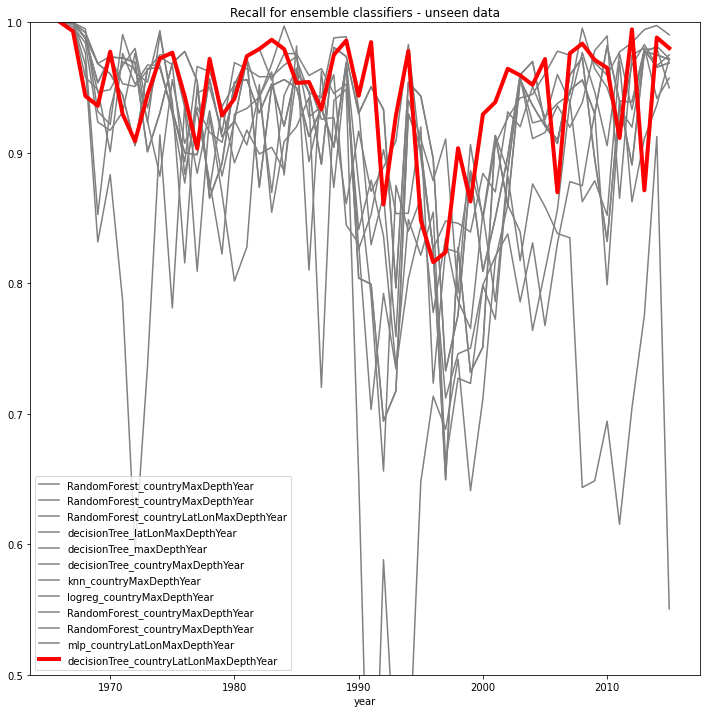

In [117]:
fig_ens_recall = matplotlib.pyplot.figure('results_ens_unseen', figsize=(12,12))
ax_ens_recall = fig_ens_recall.add_subplot(1,1,1, title='Recall for ensemble classifiers - unseen data')

metrics_recall_ens_unseen.plot.line(x='year', 
                                    y= [c1 for c1 in clf_list if 'decisionTree_countryLatLonMaxDepthYear' != c1],
                                    ylim=[0.5, 1.0], 
                                    ax=ax_ens_recall,
                                    c='grey'
                                   )

metrics_recall_ens_unseen.plot.line(x='year', 
                                    y= 'decisionTree_countryLatLonMaxDepthYear',
                                    ylim=[0.5, 1.0], 
                                    ax=ax_ens_recall,
                                    c='r',
                                    linewidth=4,
                                   )


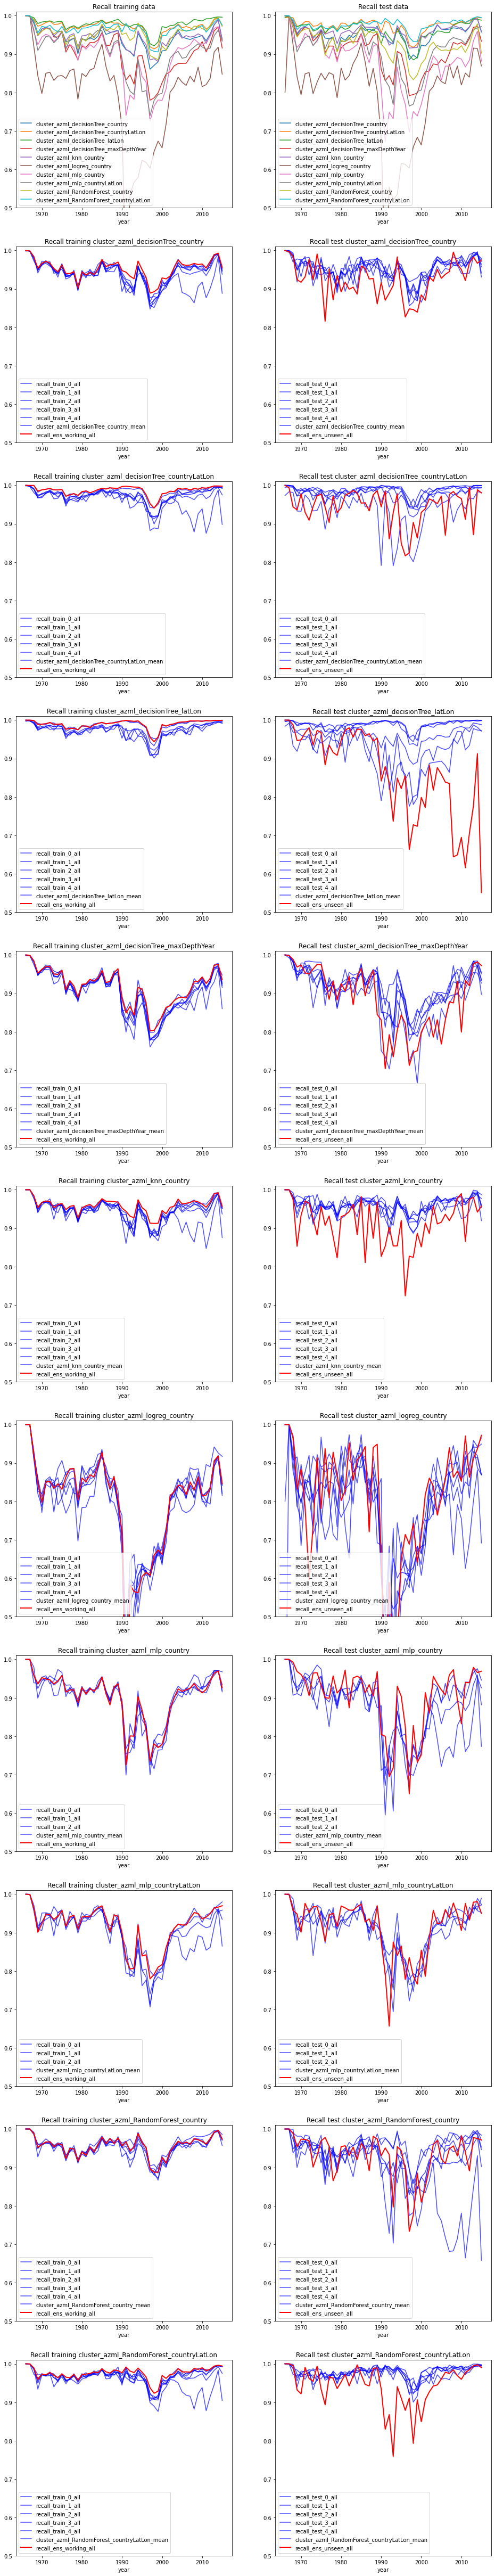

In [121]:
num_rows = len(metrics_cons_train1.keys())
ylim = [0.5,1.01]

fig_results = matplotlib.pyplot.figure('results1', figsize=(16, 8*(num_rows+1)))
ax_train = fig_results.add_subplot(num_rows+1, 2, 1, title='Recall training data')
metrics_cons_train1.plot.line(x='year', ax=ax_train, ylim=ylim)
ax_test = fig_results.add_subplot(num_rows+1, 2, 2, title='Recall test data')
metrics_cons_test1.plot.line(x='year', ax=ax_test, ylim=ylim)

# imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim)
# imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim)

ix1 = 1
for k1, v1 in metrics_train_perClassifier.items():
    ax_train = fig_results.add_subplot(num_rows+1, 2 , ix1*2 + 1, title='Recall training {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_train, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_working_all', ax=ax_train,c='r',linewidth=2.0, ylim=ylim)
#     imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_train, ylim=ylim, c='g')
    ix1 += 1
ix1 = 1    
for k1, v1 in metrics_test_perClassifier.items():
    ax_test = fig_results.add_subplot(num_rows+1, 2, ix1*2 + 2, title='Recall test {0}'.format(k1))
    v1.plot.line(x='year', ax=ax_test, ylim=[0.5,1.1],c='b',alpha=0.7)
    metrics_ens[k1].plot.line(x='year', y='recall_ens_unseen_all', ax=ax_test,c='r',linewidth=2.0, ylim=ylim)
#     imeta_metrics.plot.line(x='year',y='imeta_instr_recall_all', ax=ax_test, ylim=ylim,c='g')
    ix1 += 1

### Finding the winner - maximum unseen scores

In [122]:
scores_dict = {}
with tempfile.TemporaryDirectory() as temp_dir1:
    for exp_name, run_obj in run_dict.items():
        metrics_filename = [f1 for f1 in run_obj.get_file_names() if 'xbt_score' in f1][0]
        run_obj.download_file(metrics_filename, temp_dir1)
        current_exp_scores = pandas.read_csv(os.path.join(temp_dir1, metrics_filename))
        scores_dict[exp_name] = current_exp_scores

In [126]:
current_metric = 'recall_all'

In [127]:
current_subset = 'train'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_dict.items()])

,name,cluster_azml_decisionTree_country,cluster_azml_decisionTree_countryLatLon,cluster_azml_decisionTree_latLon,cluster_azml_decisionTree_maxDepthYear,cluster_azml_knn_country,cluster_azml_logreg_country,cluster_azml_mlp_country,cluster_azml_mlp_countryLatLon,cluster_azml_RandomForest_country,cluster_azml_RandomForest_countryLatLon
0,ens_working,0.947176,0.983457,0.986444,0.908398,0.955512,0.792966,0.892462,0.907771,0.950288,0.972061
1,train_0,0.922312,0.950633,0.985796,0.886105,0.927327,0.785873,0.897420,0.878483,0.951295,0.946469
2,train_1,0.940747,0.970857,0.967483,0.898938,0.947721,0.782162,0.889377,0.905481,0.944039,0.965596
3,train_2,0.935203,0.967912,0.967294,0.896802,0.944096,0.775259,0.887857,0.898232,0.951250,0.964395


In [129]:
current_subset = 'test'
functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_dict.items()])

,name,cluster_azml_decisionTree_country,cluster_azml_decisionTree_countryLatLon,cluster_azml_decisionTree_latLon,cluster_azml_decisionTree_maxDepthYear,cluster_azml_knn_country,cluster_azml_logreg_country,cluster_azml_mlp_country,cluster_azml_mlp_countryLatLon,cluster_azml_RandomForest_country,cluster_azml_RandomForest_countryLatLon
0,test_0,0.950577,0.986639,0.917228,0.920238,0.962328,0.812843,0.839606,0.909062,0.855601,0.976087
1,test_1,0.935379,0.975737,0.984225,0.893852,0.948071,0.790038,0.876331,0.900728,0.951974,0.966388
2,test_2,0.951945,0.981304,0.985656,0.910628,0.957366,0.788129,0.885526,0.896637,0.924565,0.974251


In [132]:
current_subset = 'unseen'
recall_unseen_df = functools.reduce(lambda x,y: pandas.merge(x, y, on='name'), [pandas.DataFrame({'name': df_score[df_score.subset ==current_subset]['name'], exp: df_score[df_score.subset == current_subset][current_metric]}) for exp, df_score in scores_dict.items()])
recall_unseen_df

,name,cluster_azml_decisionTree_country,cluster_azml_decisionTree_countryLatLon,cluster_azml_decisionTree_latLon,cluster_azml_decisionTree_maxDepthYear,cluster_azml_knn_country,cluster_azml_logreg_country,cluster_azml_mlp_country,cluster_azml_mlp_countryLatLon,cluster_azml_RandomForest_country,cluster_azml_RandomForest_countryLatLon
0,ens_unseen,0.916176,0.936351,0.829933,0.879019,0.905544,0.810509,0.897104,0.911099,0.922655,0.940504
1,unseen_0,0.912692,0.920275,0.815991,0.874351,0.903610,0.820731,0.893997,0.907900,0.921129,0.938494
2,unseen_1,0.912253,0.927786,0.821751,0.870436,0.902948,0.803868,0.881107,0.907528,0.918560,0.939585
3,unseen_2,0.911268,0.928322,0.828152,0.872369,0.898672,0.797210,0.885777,0.896193,0.921709,0.937567


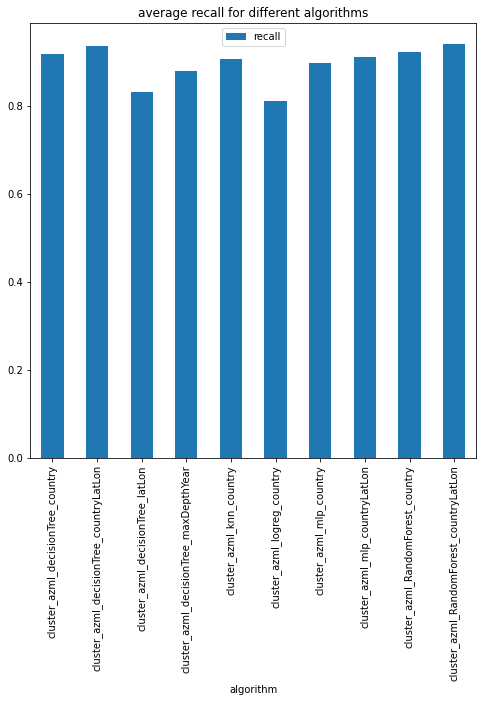

In [134]:
fig_avg_recall = matplotlib.pyplot.figure('avg_recall', figsize=(8,8))
ax_avg_recall = fig_avg_recall.add_subplot(1,1,1, title='average recall for different algorithms')
pandas.DataFrame.from_records([{'algorithm': k1, 'recall': float(s1[s1.name == 'ens_unseen']['recall_all'])} for k1, s1 in scores_dict.items()]).plot.bar(x='algorithm', ax=ax_avg_recall)
# fig_avg_recall.savefig(os.path.join(xbt_plots_dir, 'xbt_avg_recall_unseen.png'),bbox_inches='tight')